In [ ]:
!pip install efficientnet_pytorch
!pip install transformers

from efficientnet_pytorch import EfficientNet

import torch
import torch.utils.data as Data
import torch.nn as nn
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.special import softmax
import cv2
from transformers import get_cosine_schedule_with_warmup
from transformers import AdamW
from tqdm.notebook import tqdm
from albumentations import *
from albumentations.pytorch import ToTensor
import gc

import warnings
warnings.filterwarnings("ignore")

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=86ad76db03477c8fad0429d6b9e9d99db90de411d377590c3fb0112a2201e848
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
     |████████████████████████████████| 1.4MB 9.1MB/s 
     |████████████████████████████████| 2.9MB 24.0MB/s 
     |████████████████████████████████| 890kB 54.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=99e47431e385961276ca0bbe607d66405c31473811b8ed7f9ec3c149d179ab5c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Visualize a leaf of each category

The categories include "healthy", "scab", "rust", and "multiple diseases". Solving this problem is important because diagnosing plant diseases early can save tonnes of agricultural produce every year. This will benefit not only the general population by reducing hunger, but also the farmers by ensuring they get the harvest they deserve.


In [ ]:
im_healthy = plt.imread('/content/drive/MyDrive/SML/images/Train_2.jpg', format = 'jpg')
im_multi = plt.imread('/content/drive/MyDrive/SML/images/Train_1.jpg', format = 'jpg')
im_rust = plt.imread('/content/drive/MyDrive/SML/images/Train_3.jpg', format = 'jpg')
im_scab = plt.imread('/content/drive/MyDrive/SML/images/Train_0.jpg', format = 'jpg')

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(im_healthy)
ax.set_title('Healthy', fontsize = 20)

ax = fig.add_subplot(2, 2, 2)
ax.imshow(im_multi)
ax.set_title('Multiple Diseases', fontsize = 20)

ax = fig.add_subplot(2, 2, 3)
ax.imshow(im_rust)
ax.set_title('Rust', fontsize = 20)

ax = fig.add_subplot(2, 2, 4)
ax.imshow(im_scab)
ax.set_title('Scab', fontsize = 20)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Load image paths and labels into DataFrame

The dataset images are loaded, resized to the desired size and saved as .npy files. This allows them to be loaded up really fast, preventing the data loading process from bottlenecking the GPU training.

[The .npy files can be accessed here](http://www.kaggle.com/dataset/cbf0d20bb9deea2b794018659843387bd18e2a8638fae654e996c2b660cfdffb)

In [ ]:
IMAGE_FOLDER = '/content/drive/MyDrive/SML/image_pickles/'

def get_image_path(filename):
    return (IMAGE_FOLDER + filename + '.npy')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/SML/train.csv')
test = pd.read_csv('/content/drive/MyDrive/SML/test.csv')

train['image_path'] = train['image_id'].apply(get_image_path)
test['image_path'] = test['image_id'].apply(get_image_path)
train_labels = train.loc[:, 'healthy':'scab']
train_paths = train.image_path
test_paths = test.image_path

## Create train-validation split

In [ ]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, train_labels, test_size = 0.2, random_state=23, stratify = train_labels)
train_paths.reset_index(drop=True,inplace=True)
train_labels.reset_index(drop=True,inplace=True)
valid_paths.reset_index(drop=True,inplace=True)
valid_labels.reset_index(drop=True,inplace=True)

In [ ]:
class LeafDataset(Data.Dataset):
    def __init__(self, image_paths, labels = None, train = True, test = False):
        self.paths = image_paths
        self.test = test
        if self.test == False:
            self.labels = labels
        self.train = train
        self.train_transform = Compose([HorizontalFlip(p=0.5),
                                  VerticalFlip(p=0.5),
                                  ShiftScaleRotate(rotate_limit=25.0, p=0.7),
                                  OneOf([IAAEmboss(p=1),
                                         IAASharpen(p=1),
                                         Blur(p=1)], p=0.5),
                                  IAAPiecewiseAffine(p=0.5)])
        self.test_transform = Compose([HorizontalFlip(p=0.5),
                                       VerticalFlip(p=0.5),
                                       ShiftScaleRotate(rotate_limit=25.0, p=0.7)])
        self.default_transform = Compose([Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
                                         ToTensor()]) #normalized for pretrained network
        
    def __len__(self):
        return self.paths.shape[0]
    
    def __getitem__(self, i):
        image = np.load(self.paths[i]) #load from .npy file!
        if self.test==False:
            label = torch.tensor(np.argmax(self.labels.loc[i,:].values)) #loss function used later doesnt take one-hot encoded labels, so convert it using argmax
        if self.train:
            image = self.train_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        elif self.test:
            image = self.test_transform(image=image)['image']
            image = self.default_transform(image=image)['image']
        else:
            image = self.default_transform(image=image)['image']
        
        if self.test==False:
            return image, label
        return image

## Define training, validation and test functions

In [ ]:
def train_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Training')
    
    for _, (images, labels) in enumerate(loader):
        
        images, labels = images.to(device), labels.to(device)
        net.train()
        optimizer.zero_grad()
        predictions = net(images)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()*labels.shape[0]
        labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
        preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
        
        pbar.update()
        
    accuracy = accuracy_score(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/TRAIN_SIZE, accuracy

def valid_fn(net, loader):
    
    running_loss = 0
    preds_for_acc = []
    labels_for_acc = []
    
    pbar = tqdm(total = len(loader), desc='Validation')
    
    with torch.no_grad():       #torch.no_grad() prevents Autograd engine from storing intermediate values, saving memory
        for _, (images, labels) in enumerate(loader):
            
            images, labels = images.to(device), labels.to(device)
            net.eval()
            predictions = net(images)
            loss = loss_fn(predictions, labels)
            
            running_loss += loss.item()*labels.shape[0]
            labels_for_acc = np.concatenate((labels_for_acc, labels.cpu().numpy()), 0)
            preds_for_acc = np.concatenate((preds_for_acc, np.argmax(predictions.cpu().detach().numpy(), 1)), 0)
            
            pbar.update()
            
        accuracy = accuracy_score(labels_for_acc, preds_for_acc)
        conf_mat = confusion_matrix(labels_for_acc, preds_for_acc)
    
    pbar.close()
    return running_loss/VALID_SIZE, accuracy, conf_mat

def test_fn(net, loader):

    preds_for_output = np.zeros((1,4))
    
    with torch.no_grad():
        pbar = tqdm(total = len(loader))
        for _, images in enumerate(loader):
            images = images.to(device)
            net.eval()
            predictions = net(images)
            preds_for_output = np.concatenate((preds_for_output, predictions.cpu().detach().numpy()), 0)
            pbar.update()
    
    pbar.close()
    return preds_for_output

## Initialize

In [ ]:
BATCH_SIZE = 6
NUM_EPOCHS = 30
TRAIN_SIZE = train_labels.shape[0]
VALID_SIZE = valid_labels.shape[0]
MODEL_NAME = 'efficientnet-b5'
device = 'cuda'
lr = 8e-4

In [ ]:
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 2)

valid_dataset = LeafDataset(valid_paths, valid_labels, train = False)
validloader = Data.DataLoader(valid_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

test_dataset = LeafDataset(test_paths, train = False, test = True)
testloader = Data.DataLoader(test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = 2)

## EfficientNetB5

B5 is the largest EfficientNet variant that fits in GPU memory with batch size 8.

In [ ]:
model = EfficientNet.from_pretrained(MODEL_NAME)

num_ftrs = model._fc.in_features
model._fc = nn.Sequential(nn.Linear(num_ftrs,1000,bias=True),
                          nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(1000,4, bias = True))

model.to(device)
optimizer = AdamW(model.parameters(), lr = lr, weight_decay = 1e-3)
num_train_steps = int(len(train_dataset) / BATCH_SIZE * NUM_EPOCHS)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=len(train_dataset)/BATCH_SIZE*5, num_training_steps=num_train_steps)
loss_fn = torch.nn.CrossEntropyLoss()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth



Loaded pretrained weights for efficientnet-b5


## Main training loop

In [ ]:
train_loss = []
valid_loss = []
train_acc = []
val_acc = []

In [ ]:
for epoch in range(NUM_EPOCHS):
    
    tl, ta = train_fn(model, loader = trainloader)
    vl, va, conf_mat = valid_fn(model, loader = validloader)
    train_loss.append(tl)
    valid_loss.append(vl)
    train_acc.append(ta)
    val_acc.append(va)
    
    if (epoch+1)%10==0:
        path = 'epoch' + str(epoch) + '.pt'
        torch.save(model.state_dict(), path)
    
    printstr = 'Epoch: '+ str(epoch) + ', Train loss: ' + str(tl) + ', Val loss: ' + str(vl) + ', Train acc: ' + str(ta) + ', Val acc: ' + str(va)
    tqdm.write(printstr)
    
'''Output hidden. Unhide to see training log'''


Epoch: 0, Train loss: 0.955072113220672, Val loss: 0.35865374821914386, Train acc: 0.6387362637362637, Val acc: 0.8767123287671232



Epoch: 1, Train loss: 0.4434543742317256, Val loss: 0.18961010236701328, Train acc: 0.8633241758241759, Val acc: 0.947945205479452



Epoch: 2, Train loss: 0.4104183766578969, Val loss: 0.4345407181706484, Train acc: 0.8701923076923077, Val acc: 0.8904109589041096



Epoch: 3, Train loss: 0.3689816453293283, Val loss: 0.47316721746162194, Train acc: 0.8866758241758241, Val acc: 0.8684931506849315



Epoch: 4, Train loss: 0.4358645410633231, Val loss: 1.776625501905402, Train acc: 0.8633241758241759, Val acc: 0.5616438356164384



Epoch: 5, Train loss: 0.33786465541349603, Val loss: 0.25319929294900534, Train acc: 0.8997252747252747, Val acc: 0.9123287671232877



Epoch: 6, Train loss: 0.3426224014508809, Val loss: 0.2762146307997508, Train acc: 0.9038461538461539, Val acc: 0.9178082191780822



Epoch: 7, Train loss: 0.26646134304378444, Val loss: 0.3081570937649079, Train acc: 0.9162087912087912, Val acc: 0.9315068493150684



Epoch: 8, Train loss: 0.24437948443944782, Val loss: 0.23512187921761038, Train acc: 0.9175824175824175, Val acc: 0.9287671232876712



Epoch: 9, Train loss: 0.19206283297423327, Val loss: 0.33172483535560027, Train acc: 0.9471153846153846, Val acc: 0.915068493150685



Epoch: 10, Train loss: 0.2506081783191933, Val loss: 0.2596162852703606, Train acc: 0.9244505494505495, Val acc: 0.9260273972602739



Epoch: 11, Train loss: 0.2044876717868297, Val loss: 0.32218631064704273, Train acc: 0.9368131868131868, Val acc: 0.9178082191780822



Epoch: 12, Train loss: 0.16749774058973924, Val loss: 0.19862018227385841, Train acc: 0.9457417582417582, Val acc: 0.9315068493150684



Epoch: 13, Train loss: 0.1695316073289707, Val loss: 0.1972927087710609, Train acc: 0.9464285714285714, Val acc: 0.9342465753424658



Epoch: 14, Train loss: 0.16955075261268956, Val loss: 0.28501450077798823, Train acc: 0.9457417582417582, Val acc: 0.9178082191780822



Epoch: 15, Train loss: 0.13110365685973263, Val loss: 0.18996756816456695, Train acc: 0.9567307692307693, Val acc: 0.9424657534246575



Epoch: 16, Train loss: 0.11639658110732773, Val loss: 0.2791387866889063, Train acc: 0.9608516483516484, Val acc: 0.9123287671232877



Epoch: 17, Train loss: 0.08520585148395625, Val loss: 0.17166533936477657, Train acc: 0.970467032967033, Val acc: 0.9671232876712329



Epoch: 18, Train loss: 0.0962123931718067, Val loss: 0.12618970789815848, Train acc: 0.9718406593406593, Val acc: 0.9671232876712329



Epoch: 19, Train loss: 0.07821222101788558, Val loss: 0.12516284007523273, Train acc: 0.9759615384615384, Val acc: 0.9561643835616438



Epoch: 20, Train loss: 0.06680051648451339, Val loss: 0.12287708531343737, Train acc: 0.978021978021978, Val acc: 0.9643835616438357



Epoch: 21, Train loss: 0.042092792173509606, Val loss: 0.11118789327358596, Train acc: 0.9848901098901099, Val acc: 0.9753424657534246



Epoch: 22, Train loss: 0.042264236141538555, Val loss: 0.10844021242086804, Train acc: 0.9869505494505495, Val acc: 0.9698630136986301



Epoch: 23, Train loss: 0.03931422132763231, Val loss: 0.10442425659938923, Train acc: 0.9814560439560439, Val acc: 0.9808219178082191



Epoch: 24, Train loss: 0.023344696357298744, Val loss: 0.10575848404726844, Train acc: 0.992445054945055, Val acc: 0.9808219178082191



Epoch: 25, Train loss: 0.028852327686990975, Val loss: 0.08435580129002095, Train acc: 0.989010989010989, Val acc: 0.9808219178082191



Epoch: 26, Train loss: 0.023805999535114267, Val loss: 0.08618497853925848, Train acc: 0.992445054945055, Val acc: 0.9780821917808219



Epoch: 27, Train loss: 0.02249852236903175, Val loss: 0.08703158603448796, Train acc: 0.9917582417582418, Val acc: 0.9808219178082191



Epoch: 28, Train loss: 0.016733360107947407, Val loss: 0.0900038358555919, Train acc: 0.9931318681318682, Val acc: 0.9808219178082191



Epoch: 29, Train loss: 0.016445191390434356, Val loss: 0.08912170642892406, Train acc: 0.9945054945054945, Val acc: 0.9808219178082191


'Output hidden. Unhide to see training log'

## Plots of training and validation loss and accuracy

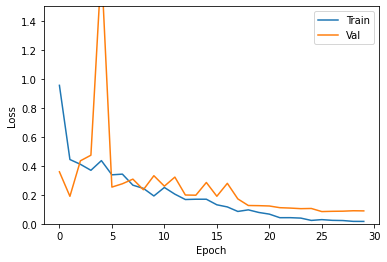

In [ ]:
plt.figure()
plt.ylim(0,1.5)
sns.lineplot(list(range(len(train_loss))), train_loss)
sns.lineplot(list(range(len(valid_loss))), valid_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Val'])

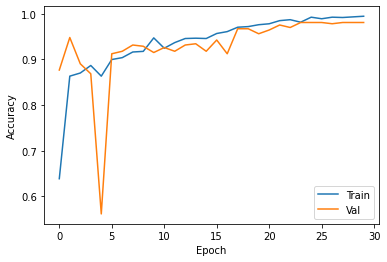

In [ ]:
plt.figure()
sns.lineplot(list(range(len(train_acc))), train_acc)
sns.lineplot(list(range(len(val_acc))), val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

## Confusion matrix

Computed on the validation set on the last epoch

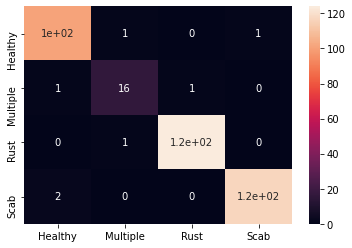

In [ ]:
labels = ['Healthy', 'Multiple','Rust','Scab']
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True)